In [11]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset
from torchvision.datasets import ImageFolder

import os, shutil
import torch.nn.functional as F

import torch.optim as optim
from torchvision import datasets, transforms

import h5py
import PIL.Image
import numpy as np
import matplotlib.pyplot as plt


import torchvision
from torchvision.models import vgg16

In [12]:
original_dataset_dir = 'C:/Users/pauli/Documents/M2/ML et DL/projet/Git/DamageDetection'

In [13]:
train_damage_dir = original_dataset_dir + '/train_another/damage'
validation_damage_dir = original_dataset_dir + '/validation_another/damage'
test_damage_dir = original_dataset_dir + '/test/damage'

train_nodamage_dir = original_dataset_dir + '/train_another/no_damage'
validation_nodamage_dir = original_dataset_dir + '/validation_another/no_damage'
test_nodamage_dir = original_dataset_dir + '/test/no_damage'

In [14]:
print('total training damage images: ',len(os.listdir(train_damage_dir)))
print('total validation damage images: ',len(os.listdir(validation_damage_dir)))
print('total test damage images: ',len(os.listdir(test_damage_dir)))

print('total training no damage images: ',len(os.listdir(train_nodamage_dir)))
print('total validation no damage images: ',len(os.listdir(validation_nodamage_dir)))
print('total test no damage images: ',len(os.listdir(test_nodamage_dir)))

total training damage images:  5000
total validation damage images:  1000
total test damage images:  1000
total training no damage images:  5000
total validation no damage images:  1000
total test no damage images:  1000


In [44]:
    
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1)
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv4 = nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, stride=1, padding=1)
        self.pool4 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc1 = nn.Linear(in_features=10368, out_features=512)
        self.fc2 = nn.Linear(in_features=512, out_features=1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.pool1(F.relu(self.conv1(x)))
        x = self.pool2(F.relu(self.conv2(x)))
        x = self.pool3(F.relu(self.conv3(x)))
        x = self.pool4(F.relu(self.conv4(x)))
        x = x.view(-1, 10368)
        x = F.relu(self.fc1(x))
        x = torch.sigmoid(self.fc2(x))
        return x
    
    

In [45]:
model = Net()

In [46]:
model

Net(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv4): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=10368, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)

In [47]:
criterion = nn.BCELoss()
optimizer = optim.RMSprop(model.parameters(), lr=1e-4)

In [48]:

train_datagen = transforms.Compose([
    transforms.Resize((150, 150)),
    transforms.ToTensor(),
    #transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    transforms.Normalize((0,), (1/255,))
])

train_dataset = ImageFolder('C:/Users/pauli/Documents/M2/ML et DL/projet/Git/DamageDetection/train_another', transform=train_datagen)
train_loader = DataLoader(train_dataset, batch_size=20, shuffle=True)

validation_datagen = transforms.Compose([
    transforms.Resize((150, 150)),
    transforms.ToTensor(),
    #transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    transforms.Normalize((0,), (1/255,))
])

val_dataset = ImageFolder('C:/Users/pauli/Documents/M2/ML et DL/projet/Git/DamageDetection/validation_another', transform=validation_datagen)
val_loader = DataLoader(val_dataset, batch_size=20, shuffle=True)



In [ ]:
epoch_nums = []
training_loss = []
validation_loss = []
training_acc = []
validation_acc = []

for epoch in range(5):
    train_loss = 0.0
    train_acc = 0.0
    val_loss = 0.0
    val_acc = 0.0
    
    # Entraînement du modèle
    model.train()
    for i, data in enumerate(train_loader, 0):
        inputs, labels = data
        labels = labels.unsqueeze(1)
        optimizer.zero_grad()        
        outputs = model(inputs)
        loss = criterion(outputs, labels.float())
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        train_acc += (outputs.round().squeeze().long() == labels).float().mean().item()

    # Évaluation du modèle sur les données de validation
    model.eval()
    with torch.no_grad():
        for data in val_loader:
            inputs, labels = data
            labels = labels.unsqueeze(1)
            outputs = model(inputs)
            loss = criterion(outputs, labels.float())
            val_loss += loss.item()
            val_acc += (outputs.round().squeeze().long() == labels).float().mean().item()

    train_loss /= len(train_loader)
    train_acc /= len(train_loader)
    val_loss /= len(val_loader)
    val_acc /= len(val_loader)
    
    epoch_nums.append(epoch + 1)
    training_loss.append(train_loss)
    validation_loss.append(val_loss)
    training_acc.append(train_acc)
    validation_acc.append(val_acc)
    
    print("Epoch {}/{}".format(epoch + 1, 5))
    print("Training loss: {:.4f}, accuracy: {:.4f}".format(train_loss, train_acc))
    print("Validation loss: {:.4f}, accuracy: {:.4f}".format(val_loss, val_acc))

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x000001A05A668CA8>
Traceback (most recent call last):
  File "C:\Users\pauli\anaconda3\envs\DL\lib\site-packages\torch\utils\data\dataloader.py", line 1466, in __del__
    self._shutdown_workers()
  File "C:\Users\pauli\anaconda3\envs\DL\lib\site-packages\torch\utils\data\dataloader.py", line 1424, in _shutdown_workers
    if self._persistent_workers or self._workers_status[worker_id]:
AttributeError: '_MultiProcessingDataLoaderIter' object has no attribute '_workers_status'


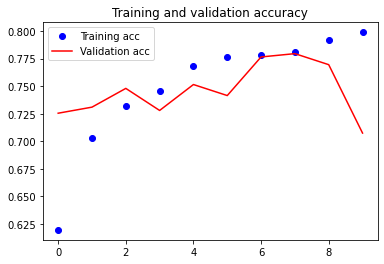

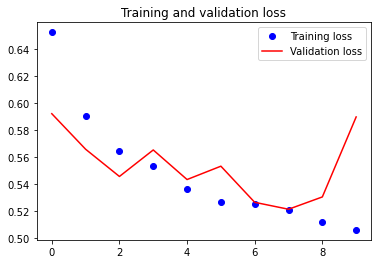

In [19]:

plt.plot(epoch_nums, training_acc, 'bo', label = 'Training acc')
plt.plot(epoch_nums, validation_acc, 'r', label = 'Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()
plt.plot(epoch_nums, training_loss, 'bo', label = 'Training loss')
plt.plot(epoch_nums, validation_loss, 'r', label = 'Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()